# Notable Assessment

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import itertools

In [2]:
%matplotlib inline

In [3]:
def initialize_figure():
    """
    This function intizilatized figures and removes the top and right axes.
    """
    fig, ax = plt.subplots(figsize=(10,6))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    return fig, ax

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = initialize_figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, axes=ax)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Data Exploration

In [5]:
df = pd.read_csv('Downloads/AP_ICD10.tsv', sep='\t', header=0)

In [28]:
print(len(df))
print(df.dtypes)

248
chf cmplnt                 object
A/P                        object
icd10encounterdiagcode     object
icd10encounterdiagdescr    object
predict                    object
text1                      object
text2                      object
text1_len                   int64
text2_len                   int64
num                         int64
dtype: object


In [7]:
df['predict'] = df['icd10encounterdiagcode'].astype('str').apply(lambda x: x[:3])

In [8]:
df.head()

,chf cmplnt,A/P,icd10encounterdiagcode,icd10encounterdiagdescr,predict
0,"Followup: Osteoarthritis of hip; Hip pain, Pos...",Doing well post-op. Progressing as expected. o...,M1612,"M1612: Unilateral primary osteoarthritis, left...",M16
1,"Knee pain, Post Op",The fracture is healing well in good alignment...,S82025A,S82025A: Nondisplaced longitudinal fracture of...,S82
2,Followup: Osteoarthritis of knee; Knee pain,Osteoarthritis of the Right knee.The patient e...,M1711,"M1711: Unilateral primary osteoarthritis, righ...",M17
3,Hip pain,Left hip Trocanteric Bursitis. trochanteric bu...,M7062,"M7062: Trochanteric bursitis, left hip",M70
4,"Knee pain, Post Op",Left Medial Meniscus Tear. Doing well post-op....,S83222A,"S83222A: Prph tear of medial meniscus, current...",S83


In [9]:
df.icd10encounterdiagcode[df.icd10encounterdiagcode.isnull()]

34     NaN
80     NaN
121    NaN
122    NaN
158    NaN
159    NaN
199    NaN
200    NaN
Name: icd10encounterdiagcode, dtype: object

In [10]:
len(df['predict'].unique())

35

In [12]:
df['text1'] = df['chf cmplnt'].astype('str').apply(nltk.word_tokenize).apply(lambda x:[i.lower() for i in x])
df['text2'] = df['A/P'].astype('str').apply(nltk.word_tokenize).apply(lambda x:[i.lower() for i in x])

In [13]:
df['text1_len'] = df['text1'].apply(len)
df['text2_len'] = df['text2'].apply(len)

In [14]:
print(df['text1_len'].min())
print(df['text1_len'].mean())
print(df['text1_len'].max())

print(df['text2_len'].min())
print(df['text2_len'].mean())
print(df['text2_len'].max())

1
5.806451612903226
15
1
31.06451612903226
225


### Data Processing

In [15]:
label_map = dict([(k,i) for i,k in enumerate(df.predict.unique())])

In [16]:
df['num'] = df.predict.apply(lambda x: label_map[x])

In [17]:
transformer = TfidfTransformer(smooth_idf=False)
vectorizer = CountVectorizer() 

In [18]:
text1 = transformer.fit_transform(vectorizer.fit_transform(df['chf cmplnt'][~df['chf cmplnt'].isna()])).toarray()
text2 = transformer.fit_transform(vectorizer.fit_transform(df['A/P'][~df['chf cmplnt'].isna()])).toarray()

In [19]:
x = np.concatenate([text1, text2], axis=1)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, df.num[~df['chf cmplnt'].isna()], test_size=0.2)

### Training

In [21]:
from sklearn.naive_bayes import MultinomialNB

In [22]:
clf = MultinomialNB(alpha=1)

In [23]:
clf.fit(x_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

### Evaluation

In [24]:
pred = clf.predict(x_test)

In [25]:
cfm = confusion_matrix(y_test, pred)

In [26]:
labels_ord = [x for x,_ in sorted([(key, value) for key, value in label_map.items()], key=lambda x: x[1])]

Confusion matrix, without normalization
[[3 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


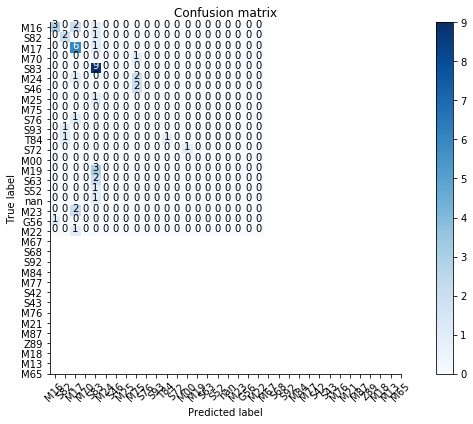

In [27]:
plot_confusion_matrix(cfm, labels_ord)